# Simple models

This notebook picks selected simple models from the [LeNet page](http://yann.lecun.com/exdb/mnist/) and performs setup as described in `[1]`, evaluating their performance on the MNIST classification task.  The evaluation uses 5-fold cross-validation with a stratified split strategy, and reports the error rate.

`[1]` - [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf),  LeCun et al, Nov 1998

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

plt.style.use('fivethirtyeight')
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Consolas'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2

%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

## Load pickle files

In [2]:
# Set up the file directory and names
DIR = '../input/'
X_TRAIN = DIR + 'train-images-idx3-ubyte.pkl'
Y_TRAIN = DIR + 'train-labels-idx1-ubyte.pkl'
X_TEST = DIR + 't10k-images-idx3-ubyte.pkl'
Y_TEST = DIR + 't10k-labels-idx1-ubyte.pkl'

print('Loading pickle files ...')
X_train = pickle.load( open( X_TRAIN, "rb" ) )
y_train = pickle.load( open( Y_TRAIN, "rb" ) )
X_test = pickle.load( open( X_TEST, "rb" ) )
y_test = pickle.load( open( Y_TEST, "rb" ) )

n_train = X_train.shape[0]
n_test = X_test.shape[0]

w = X_train.shape[1]
h = X_train.shape[2]

# Reshape the images so they're a single row in the numpy array
X_train_input = X_train.reshape((n_train, w * h))
X_test_input = X_test.reshape((n_test, w * h))
y_train_input = y_train.squeeze()
y_test_input = y_test.squeeze()

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print('Loaded train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Loaded test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))

Loading pickle files ...
Loaded train images shape (60000, 28, 28), labels shape (60000, 1)
Loaded test images shape (10000, 28, 28), labels shape (10000, 1)


## Helper functions

Before trying a few different algorithms out, let's define a reusable set of functions to cross-validate and predict on the test set. Because scikit-learn has such a uniform interface, we can re-use these on pretty much any classification algorithm out there.

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(model, scoring, X, y, n_folds, n_jobs, random_state):
    ''' Evaluates the performance of a model using X and y with n_folds cross validation'''
#     print('Running {}-fold cross validation on {} examples ..'.format(n_folds, count))
    cv = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
    accuracies = cross_val_score(estimator=model, X=X, y=y, cv=cv, scoring=scoring, 
                                 n_jobs=n_jobs, verbose=0)
    errors = [1 - acc for acc in accuracies]
    return errors

def train_model(model, X, y, random_state):
    ''' Trains and returns model'''
#     print('Training model with {} examples ..'.format(n_examples))
    model_fit = model.fit(X, y)
    return model_fit

def train_and_predict(model, X_train, y_train, X_test, random_state):
    ''' Trains and makes prediction'''
    fit_model = train_model(model, X_train, y_train, random_state)
    y_test_pred = fit_model.predict(X_test)
    return y_test_pred

def train_and_evaluate(model, X_train, y_train, X_test, y_test, random_state):
    ''' Trains the model, predicts on test set, evaluates performance'''
    fit_model = train_model(model, X_train, y_train, random_state)
    acc = fit_model.score(X_test, y_test)
    error = 1.0 - acc
    return error
    
def mean_std(values):
    '''Calculates the mean and std dev of the input values
    INPUT: List or numpy array of values
    RETURNS (mean, std)
    '''
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

## Global setup

There are a couple of different ways to speed up the training. We can spread the work over multiple cores (if the algorithm supports it), this is controlled in scikit-learn's `n_jobs` parameters. We can also reduce the training set, which will decrease the performance of algorithms. But if all algorithms are operating from the same reduced training dataset, we can still compare relative performance. Testing always has to be done on the full set.

In [4]:
from sklearn.model_selection import train_test_split

N_JOBS=-2 # Leave 1 core free for UI updates
VERBOSE=1 # 3 is the most verbose level
SEED = 1234 # Fix the seed for repeatability
MAX_ITER = 100 # L-BFGS may show warnings that it doesn't converge
N_FOLDS = 5 # How may folds to do k-folds cross validation for
RUN_CV = True # Run Cross-validation on training set?

scores = dict() # Store the scores in here

# Create a stratified, shuffled subset of the training data if needed
N = n_train # How may training examples to use
if N < n_train:
    X_train, _, y_train, _ = train_test_split(X_train_input, y_train_input, 
                                          train_size=N, random_state=SEED)
else:
    X_train = X_train_input
    y_train = y_train_input
    
X_test = X_test_input
y_test = y_test_input

print('Train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))

Train images shape (60000, 784), labels shape (60000,)
Test images shape (10000, 784), labels shape (10000,)


## [1] C.1 - Logistic regression

Logistic regression is a simple model to train that's a good baseline to work from. We're using the `multinomial` option for the model, which minimizes the error across the entire probability distribution. This most closely corresponds to the 'Pairwise linear' error rate of 7.6% in `[1]`.  Our model has a 5-fold CV error of 8.1%  on the training set, and test error of 7.49%. This is 0.11% different to the 7.6% error reported in [1] C.1, pretty close.

In [5]:
%%time

from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', 
                                  max_iter=MAX_ITER, 
                                  verbose=VERBOSE, random_state=SEED) 

if RUN_CV:
    errors = evaluate_model(model=logreg_model, scoring='accuracy', # evaluate_model converts to errors
                            X=X_train, y=y_train, n_folds=N_FOLDS, 
                            n_jobs=N_JOBS, random_state=SEED)

    cv_error_mean, cv_error_std = mean_std(errors)
    print('Logistic regression CV on {} examples. Mean error {:.6f}, Std dev {:.6f}'.format(N, cv_error_mean, cv_error_std))

test_error = train_and_evaluate(model=logreg_model, 
                                X_train=X_train, y_train=y_train, 
                                X_test=X_test, y_test=y_test, 
                                random_state=SEED)

scores['log_reg'] = test_error
print('Logistic regression error {:.6f}'.format(test_error))

/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s finished
/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.4s finished
/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s finished
/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skl

Logistic regression CV on 60000 examples. Mean error 0.080684, Std dev 0.002010
Logistic regression error 0.074800
CPU times: user 30.2 s, sys: 336 ms, total: 30.6 s
Wall time: 54.3 s


/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.5s finished


## [1] C.2 k-Nearest Neighbours

Let's try kNN to classify the numbers.  This is a non-linear classification algorithm that accepts a single hyperparameter to control the number of neighbours, `k`.  [1] C.2. used  a `k` of 3, which gave an error rate of 5% on the test set.  When we ran kNN with k=3 and Euclidean distance metric the test error was 2.95%. This was slightly higher than the deslanted data result of 2.4% reported in the paper.

In [6]:
%%time

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3, metric='euclidean', p=1, n_jobs=N_JOBS)

if RUN_CV: 
    errors = evaluate_model(knn_model, 'accuracy', X_train, y_train,  
                            n_folds=N_FOLDS, n_jobs=N_JOBS, random_state=SEED)
    cv_error_mean, cv_error_std = mean_std(errors)
    print('kNN CV on {} examples. Mean error {:.6f}, Std dev {:.6f}'.format(N, cv_error_mean, cv_error_std))

test_error = train_and_evaluate(model=knn_model, 
                                X_train=X_train, y_train=y_train, 
                                X_test=X_test, y_test=y_test, 
                                random_state=SEED)

scores['knn'] = test_error
print('kNN test error {:.6f}'.format(test_error))

kNN CV on 60000 examples. Mean error 0.028500, Std dev 0.002017
kNN test error 0.029500
CPU times: user 55min 45s, sys: 1.7 s, total: 55min 46s
Wall time: 6min 47s


## [1] C.3 PCA and Polynomial Classifier

This section of the paper uses a series of pre-processing steps to help a logistic regression (similar to C.1). The pre-processing stages are:

* Subtract the mean of each input component.
* Do a PCA on the resulting data, keeping the top 40 features explaining the variance.
* Add polynomial terms to the input features. The 40 input PCA features multiply up to 821
* Train a multinomial logistic regression on the resulting 821 features.

[1] C.3 reports a test set accuracy of 3.3%. Our model reports 3.2%, matching to within 0.1%.

In [7]:
%%time

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

N_COMP=40

### TRAIN DATA ###

# Need to subtract the mean of the training data first
print('Subtracting mean from training data')
X_train_mean = np.mean(X_train, axis=0)
X_train_pca = X_train - X_train_mean

# now do PCA, keep first 40 components
print('Projecting training data onto top {} PCA basis vectors'.format(N_COMP))
pca = PCA(n_components=N_COMP)
pca.fit(X_train_pca)
X_train_pca = pca.transform(X_train_pca)

# Create interaction terms between the 40 top PCA components
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly = poly.fit(X_train_pca)
n_poly = poly.n_output_features_
print('Generating {} interaction terms between PCA data'.format(n_poly))
X_train_pca_poly = poly.transform(X_train_pca)
print('Training data shape {}'.format(X_train_pca_poly.shape))

### TEST DATA ###

# Need to subtract the mean of the training data first
print('Subtracting mean of training data from test data')
# X_test_mean = np.mean(X_train, axis=0)
X_test_pca = X_test - X_train_mean

# Don't refit PCA to the test data ! Just transform
print('Projecting test data onto top {} PCA basis vectors'.format(N_COMP))
# pca = PCA(n_components=N_COMP)
# pca.fit(X_test_pca)
X_test_pca = pca.transform(X_test_pca)

# Generate interaction polynomical terms
# poly = PolynomialFeatures(degree=2, interaction_only=True)
# poly = poly.fit(X_test_pca)
X_test_pca_poly = poly.transform(X_test_pca)
print('Test data shape {}'.format(X_test_pca_poly.shape))

### MODEL ###
print('Training logistic regression model on PCA interaction terms')

logreg_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', 
                                  max_iter=MAX_ITER, 
                                  verbose=VERBOSE, random_state=SEED) 

if RUN_CV:
    errors = evaluate_model(model=logreg_model, scoring='accuracy', 
                            X=X_train_pca_poly, y=y_train, n_folds=N_FOLDS, 
                            n_jobs=N_JOBS, random_state=SEED)

    cv_error_mean, cv_error_std = mean_std(errors)
    print('Logistic regression CV on {} examples. Mean error {:.6f}, Std dev {:.6f}'.format(N, cv_error_mean, cv_error_std))
  

test_error = train_and_evaluate(model=logreg_model, 
                                X_train=X_train_pca_poly, y_train=y_train, 
                                X_test=X_test_pca_poly, y_test=y_test, 
                                random_state=SEED)

scores['pca_int_logreg'] = test_error
print('Logistic regression error {:.6f}'.format(test_error))

Subtracting mean from training data
Projecting training data onto top 40 PCA basis vectors
Generating 821 interaction terms between PCA data
Training data shape (60000, 821)
Subtracting mean of training data from test data
Projecting test data onto top 40 PCA basis vectors
Test data shape (10000, 821)
Training logistic regression model on PCA interaction terms


/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s finished
/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.0s finished
/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.8s finished
/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skl

Logistic regression CV on 60000 examples. Mean error 0.035017, Std dev 0.002435
Logistic regression error 0.031900
CPU times: user 1min 26s, sys: 47.2 s, total: 2min 13s
Wall time: 2min 1s


/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


## [1] C.4  Radial Basis Function Network

I'm going to skip this one for now.  RBFNs are fully connected neural nets that use RBFs as their activation function. I couldn't find anything similar in scikit learn, or Tensorflow. I might come back to this one later.


## [1]  SVM Poly 4

Although not mentioned explicitly in the sections of the paper,  Fig 9 on page 12 shows an `SVM poly 4` entry with an error of 1.1%. It would be a shame to miss out SVMs in a classification problem, so I'll check the performance here.

In [8]:
%%time

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

print('Standardising input features before SVM')
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_test)
X_test_std = scaler.transform(X_test)

print('Training SVM')
clf = SVC(C=1.0, kernel='poly', degree=4, verbose=True)

# Cross validating SVM on training data will take ~60mins
print('Evaluating SVM')
if RUN_CV:
    errors = evaluate_model(clf, 'accuracy', X_train, y_train,  
                            n_folds=N_FOLDS, n_jobs=N_JOBS, random_state=SEED)
    cv_error_mean, cv_error_std = mean_std(errors)
    print('SVM Poly-4 {} examples. Mean error {:.6f}, Std dev {:.6f}'.format(N, cv_error_mean, cv_error_std))

clf.fit(X_train_std, y_train)
accuracy = clf.score(X_test_std, y_test)
error = 1.0 - accuracy

scores['svm_poly4'] = error
print('SVM Poly-4  regression error {:.6f}'.format(error))

Standardising input features before SVM


/home/tim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Training SVM
Evaluating SVM
SVM Poly-4 60000 examples. Mean error 0.028333, Std dev 0.000950
[LibSVM]SVM Poly-4  regression error 0.132400
CPU times: user 50min 25s, sys: 12.4 s, total: 50min 37s
Wall time: 55min 37s


# Recap of scores for simple models

In [9]:
simple_scores_df = pd.DataFrame.from_dict(scores, orient='index')
simple_scores_df.columns = ['error']
simple_scores_df['error'] *= 100
simple_scores_df = simple_scores_df.sort_values('error', ascending=True)
simple_scores_df.to_pickle('simple_scores.pkl')
simple_scores_df

,error
knn,2.95
pca_int_logreg,3.19
log_reg,7.48
svm_poly4,13.24


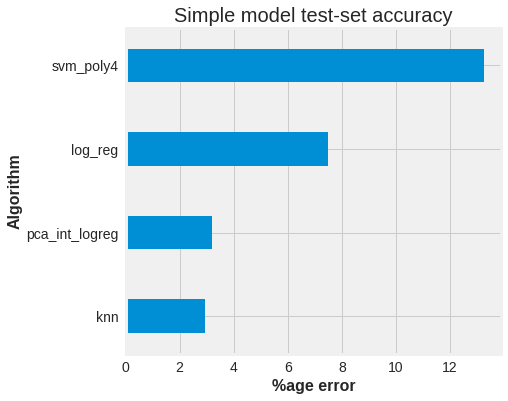

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
simple_scores_df.plot.barh(width=0.4, ax=ax, legend=None)
ax.set(title="Simple model test-set accuracy", ylabel="Algorithm", xlabel="%age error");
plt.savefig('simple_scores.png', bbox_inches='tight', dpi=150)